# Shifting Mean Anomaly

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from calcwf import gen_wf, chirp2total, shifted_f, shifted_e, get_h

/home/ben.patterson/.conda/envs/eccentric_harmonics/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


/home/ben.patterson/.conda/envs/eccentric_harmonics/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


The plot in this notebook demonstrates a waveform starting $2\pi$ earlier in mean anomaly by calculating the change in frequency and eccentricity to recover the original waveform after exactly one amplitude modulation.

In [2]:
# Parameters
f_low = 10
e = 0.2
chirp = 24
q = 2
sample_rate = 4096

In [3]:
# Create original waveform
h = gen_wf(f_low, e, chirp2total(chirp, q), q, sample_rate, 'TEOBResumS')

# Calculate shifts in frequency and eccentricity
s_f = shifted_f(f_low, e, chirp2total(chirp, q), q)
s_e = shifted_e(s_f, f_low, e)

# Create shifted waveform
s = gen_wf(s_f, s_e, chirp2total(chirp, q), q, sample_rate, 'TEOBResumS')

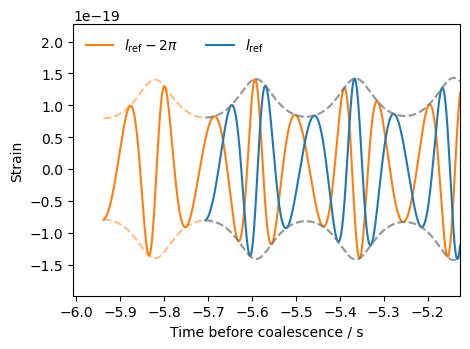

In [4]:
# Make plot, shifting 2 pi in mean anomaly
plt.figure(figsize=(0.75*6.4,0.75*4.8))
plt.plot(s.sample_times, s.real(), c='C1', label='$l_\\mathrm{ref}-2\\pi$')
plt.plot(h.sample_times, h.real(), c='C0', label='$l_\\mathrm{ref}$')
plt.plot(s.sample_times, np.abs(s), c='C1', ls='dashed', alpha=0.5)
plt.plot(h.sample_times, np.abs(h), c='C0', ls='dashed', alpha=0.5)
plt.plot(s.sample_times, -np.abs(s), c='C1', ls='dashed', alpha=0.5)
plt.plot(h.sample_times, -np.abs(h), c='C0', ls='dashed', alpha=0.5)
plt.legend(loc='upper left', frameon=False, ncol=2)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Strain')
len_2pi = h.sample_times[0]-s.sample_times[0]
plt.xlim(s.sample_times[0]-0.3*len_2pi, h.sample_times[0]+2.5*len_2pi)
max_h = max(np.abs(h[:int(1.7*len_2pi*sample_rate)]))
plt.ylim(-1.4*max_h, 1.6*max_h)
plt.tight_layout()
plt.savefig('Figures/2piMA.png', dpi=450)

## Overplotting fiducial waveforms

In [5]:
# Generate fiducial waveforms with same parameters
all_hs = get_h([1]*10, f_low, e, chirp2total(chirp, q), q, sample_rate, GS_normalisation=False)
h_tot, h0, h1, hn1, h2 = all_hs[:5]
h_sum = h0+h1+hn1+h2

/home/ben.patterson/.conda/envs/eccentric_harmonics/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


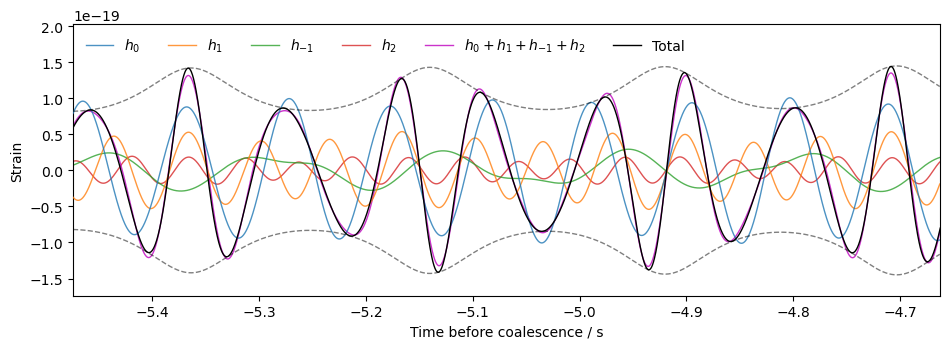

In [6]:
# Make plot
plt.figure(figsize=(1.5*6.4,0.75*4.8))
cuts = [int(1*len_2pi*sample_rate), int(4.5*len_2pi*sample_rate)]
limits = [int(1*len_2pi*sample_rate), int(4.5*len_2pi*sample_rate)]
plt.plot(h0.sample_times[cuts[0]:cuts[1]], h0[cuts[0]:cuts[1]], c='C0', label='$h_{0}$', alpha=0.8, zorder=4, lw=1)
plt.plot(h1.sample_times[cuts[0]:cuts[1]], h1[cuts[0]:cuts[1]], c='C1', label='$h_{1}$', alpha=0.8, zorder=3, lw=1)
plt.plot(hn1.sample_times[cuts[0]:cuts[1]], hn1[cuts[0]:cuts[1]], c='C2', label='$h_{-1}$', alpha=0.8, zorder=2, lw=1)
plt.plot(h2.sample_times[cuts[0]:cuts[1]], h2[cuts[0]:cuts[1]], c='C3', label='$h_{2}$', alpha=0.8, zorder=1, lw=1)
plt.plot(h_sum.sample_times[cuts[0]:cuts[1]], h_sum[cuts[0]:cuts[1]], c='m', label='$h_{0}+h_{1}+h_{-1}+h_{2}$', alpha=0.8, zorder=1, lw=1)
plt.plot(h_tot.sample_times, h_tot, c='k', label='Total', zorder=5, lw=1)
plt.plot(h_tot.sample_times[cuts[0]:cuts[1]], np.abs(h_tot[cuts[0]:cuts[1]]), c='k', alpha=0.5, ls='dashed', zorder=5, lw=1)
plt.plot(h_tot.sample_times[cuts[0]:cuts[1]], -np.abs(h_tot[cuts[0]:cuts[1]]), c='k', alpha=0.5, ls='dashed', zorder=5, lw=1)
plt.xlim(h_tot.sample_times[limits])
max_h = max(np.abs(h[:int(4.5*len_2pi*sample_rate)]))
plt.ylim(-1.2*max_h, 1.4*max_h)
plt.legend(loc='upper left', frameon=False, ncol=6)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Strain')
plt.tight_layout()
plt.savefig('Figures/EccWF_superposition.png', dpi=450)